# Covid-19 predictions

In [1]:
!pip3 install pandas_profiling --upgrade

     |████████████████████████████████| 256kB 3.9MB/s 
     |████████████████████████████████| 1.1MB 11.9MB/s 
     |████████████████████████████████| 10.1MB 15.9MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 3.1MB 37.0MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 645kB 33.0MB/s 
     |████████████████████████████████| 112kB 44.4MB/s 
     |████████████████████████████████| 296kB 35.4MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107437 sha256=22ffc6f246e4ede2704d30ba32cd6dcd051e2e5206fff0571423db624199cf73
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27099 sha256=bb0bbc92210894289e2f219cf43140ef2191c4cb190866c2cc54c74e6b66a4e7
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db0755

In [3]:
# importing libraries 
import fbprophet
from fbprophet import Prophet
# to check all the function and modules inside Prophet
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'predict_seasonal_components',
 'predict_trend',
 'predict_uncertainty',
 'predictive_samples',
 'regressor_col

## EDA

In [4]:
import pandas as pd

df = pd.read_csv("/content/covid_19_clean_complete.csv")

df.sample(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
5917,NaN,Pakistan,30.375300,69.345100,2020-02-13,0,0,0,0,Eastern Mediterranean
4085,NaN,Niger,17.607789,8.081666,2020-02-06,0,0,0,0,Africa
14985,Mayotte,France,-12.827500,45.166244,2020-03-19,3,0,0,3,Europe
47350,New Caledonia,France,-20.904305,165.618042,2020-07-21,22,0,21,1,Europe
9706,Beijing,China,40.182400,116.414200,2020-02-28,410,7,257,146,Western Pacific


In [5]:
# checking datatypes
df.dtypes

Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
Confirmed           int64
Deaths              int64
Recovered           int64
Active              int64
WHO Region         object
dtype: object

In [6]:
# parsing the date column 
df["Date"] = pd.to_datetime(df['Date'])
df.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
Active                     int64
WHO Region                object
dtype: object

In [8]:
df.shape

(49068, 10)

In [9]:
# checking for null values 
df.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

In [10]:
# checking for unique date values 
df['Date'].nunique()

188

In [13]:
# grouping by the date 
total = df.groupby(["Date"])["Confirmed", "Deaths", "Recovered", "Active"].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [14]:
total.head()

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-22,555,17,28,510
1,2020-01-23,654,18,30,606
2,2020-01-24,941,26,36,879
3,2020-01-25,1434,42,39,1353
4,2020-01-26,2118,56,52,2010


In [15]:
# automated EDA 
import pandas_profiling as pf
pf.ProfileReport(total)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Prophet model

In [16]:
# renaming column names necessary for prophet model 
df_prophet = total.rename(columns={"Date":"ds", "Confirmed":"y"})
df_prophet.head()

,ds,y,Deaths,Recovered,Active
0,2020-01-22,555,17,28,510
1,2020-01-23,654,18,30,606
2,2020-01-24,941,26,36,879
3,2020-01-25,1434,42,39,1353
4,2020-01-26,2118,56,52,2010


In [17]:
# initializing model and fitting the model
model = Prophet()
model.fit(df_prophet)
model.seasonalities

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OrderedDict([('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 10.0})])

In [18]:
# generating data to do forecasting for future days
future_global = model.make_future_dataframe(periods=30, freq="D") 
future_global.head()

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26


In [19]:
df_prophet.shape, future_global.shape

((188, 5), (218, 1))

In [20]:
# predictions on the future global data
prediction = model.predict(future_global)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-9.323896e+03,-1.243120e+05,8.504306e+04,-9.323896e+03,-9.323896e+03,-10979.704311,-10979.704311,-10979.704311,-10979.704311,-10979.704311,-10979.704311,0.0,0.0,0.0,-2.030360e+04
1,2020-01-23,-6.626094e+03,-1.130779e+05,9.798693e+04,-6.626094e+03,-6.626094e+03,-1101.212489,-1101.212489,-1101.212489,-1101.212489,-1101.212489,-1101.212489,0.0,0.0,0.0,-7.727307e+03
2,2020-01-24,-3.928293e+03,-9.841801e+04,1.133109e+05,-3.928293e+03,-3.928293e+03,10055.768575,10055.768575,10055.768575,10055.768575,10055.768575,10055.768575,0.0,0.0,0.0,6.127475e+03
3,2020-01-25,-1.230492e+03,-8.481820e+04,1.196298e+05,-1.230492e+03,-1.230492e+03,13728.634691,13728.634691,13728.634691,13728.634691,13728.634691,13728.634691,0.0,0.0,0.0,1.249814e+04
4,2020-01-26,1.467309e+03,-9.348291e+04,1.110581e+05,1.467309e+03,1.467309e+03,7278.808727,7278.808727,7278.808727,7278.808727,7278.808727,7278.808727,0.0,0.0,0.0,8.746118e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,2020-08-22,2.144165e+07,2.109789e+07,2.182713e+07,2.111445e+07,2.180518e+07,13728.634691,13728.634691,13728.634691,13728.634691,13728.634691,13728.634691,0.0,0.0,0.0,2.145538e+07
214,2020-08-23,2.164576e+07,2.127951e+07,2.205615e+07,2.130191e+07,2.203209e+07,7278.808727,7278.808727,7278.808727,7278.808727,7278.808727,7278.808727,0.0,0.0,0.0,2.165304e+07
215,2020-08-24,2.184988e+07,2.146955e+07,2.228199e+07,2.147756e+07,2.225438e+07,-2146.590152,-2146.590152,-2146.590152,-2146.590152,-2146.590152,-2146.590152,0.0,0.0,0.0,2.184773e+07
216,2020-08-25,2.205399e+07,2.164443e+07,2.249150e+07,2.166098e+07,2.248587e+07,-16835.705042,-16835.705042,-16835.705042,-16835.705042,-16835.705042,-16835.705042,0.0,0.0,0.0,2.203715e+07


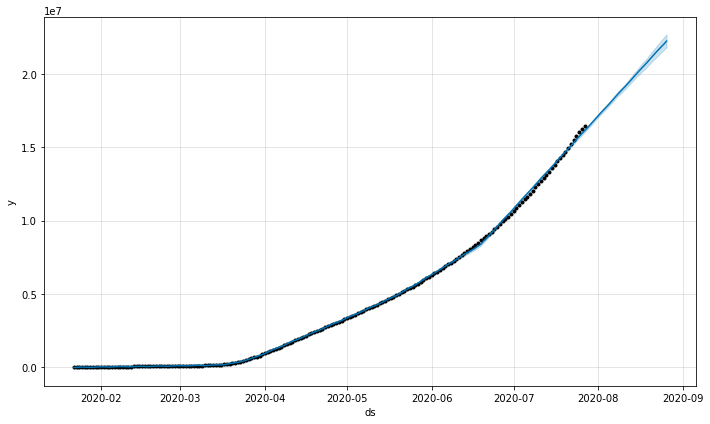

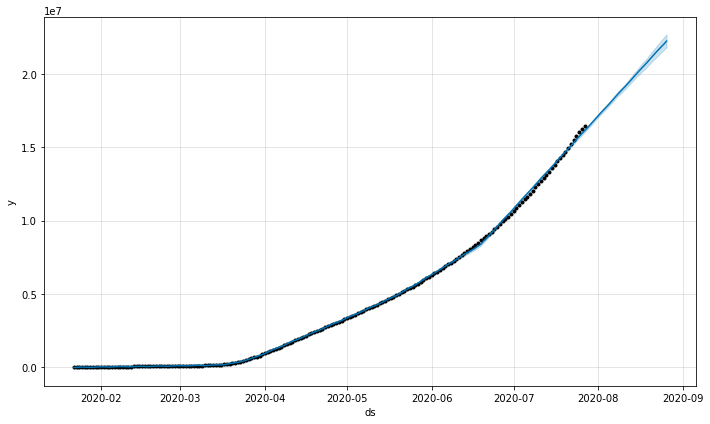

In [21]:
# plotting the prediction w.r.t yhat
model.plot(prediction)

* This is what our prediction looks like. The direction of overall case numbers is probably true, u will observe how cases rises exponentially

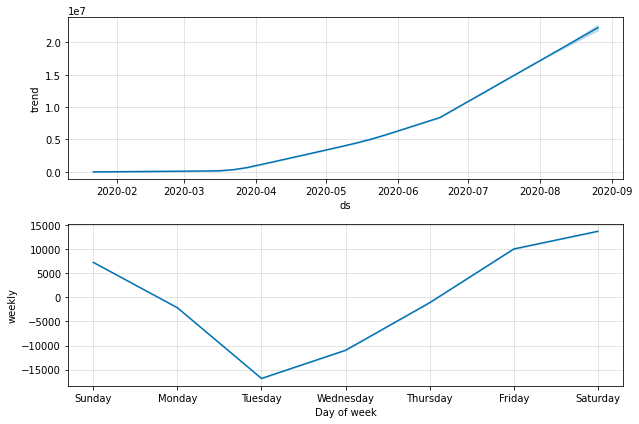

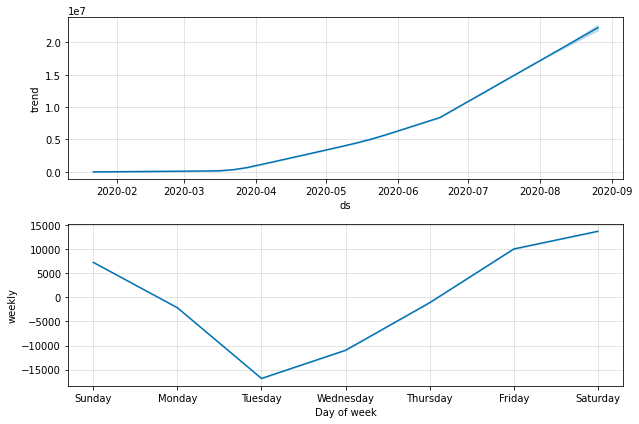

In [22]:
# visualizing each components
model.plot_components(prediction)

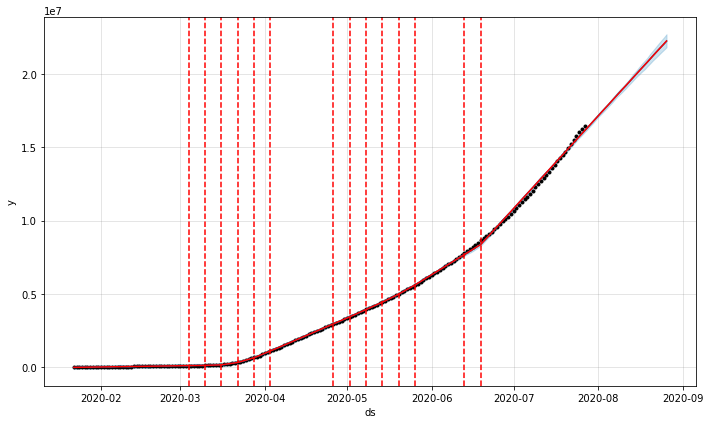

In [23]:
# prophet model identifies points at which tren changes and those can be plotted
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(prediction)

a = add_changepoints_to_plot(fig.gca(), model, prediction)

### Cross validating time series 

In [24]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, horizon="30 days", period="15 days", initial="90 days")
## horizon='365 days'--> for how many days we have to cross validate=====

## Computes forecasts from historical cutoff points Beginning from..

## (end - horizon) it means it is going to take that date that is (end - horizon) bcz on these date we have to just 
## cross-validate for the new dataset that we have to find out

## period=180 as from documentation of func as period=0.5*365=180 or {period=1/2*horizon value}
## initial -How many total no. of days we actually want-- 3*365 from documentation of function or  {initial=3*horizon}

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-04-28 00:00:00 and 2020-06-27 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-29,3.201064e+06,3.195811e+06,3.206507e+06,3185195,2020-04-28
1,2020-04-30,3.285432e+06,3.278800e+06,3.291196e+06,3268876,2020-04-28
2,2020-05-01,3.369640e+06,3.361674e+06,3.377113e+06,3355922,2020-04-28
3,2020-05-02,3.450902e+06,3.439576e+06,3.461724e+06,3437608,2020-04-28
4,2020-05-03,3.530365e+06,3.514696e+06,3.545655e+06,3515244,2020-04-28


### Performance metrics

In [26]:
from fbprophet.diagnostics import performance_metrics

df_performance = performance_metrics(df_cv)

df_performance.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.721596e+10,164972.604876,129190.213315,0.016867,0.017675,0.000000
1,4 days,3.770271e+10,194171.855844,151379.846239,0.019330,0.022485,0.000000
2,5 days,5.170151e+10,227379.657369,175214.816680,0.021780,0.025717,0.066667
3,6 days,6.937441e+10,263390.225361,202192.647173,0.024558,0.026714,0.133333
4,7 days,9.012810e+10,300213.430311,232530.254272,0.027838,0.031274,0.200000


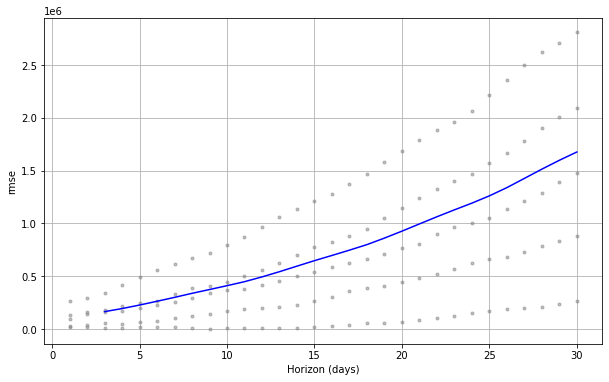

In [27]:
from fbprophet.plot import plot_cross_validation_metric

df_performance = plot_cross_validation_metric(df_cv, metric="rmse")

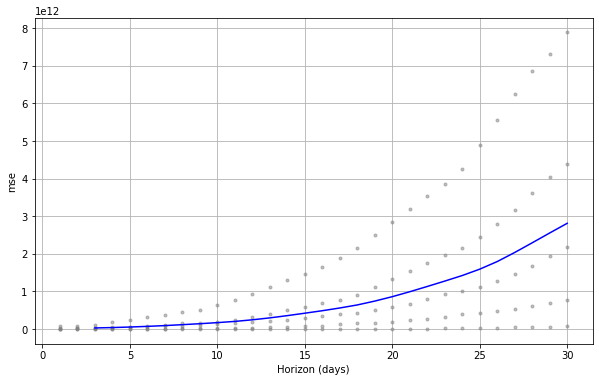

In [28]:
df_performance=plot_cross_validation_metric(df_cv,metric='mse')

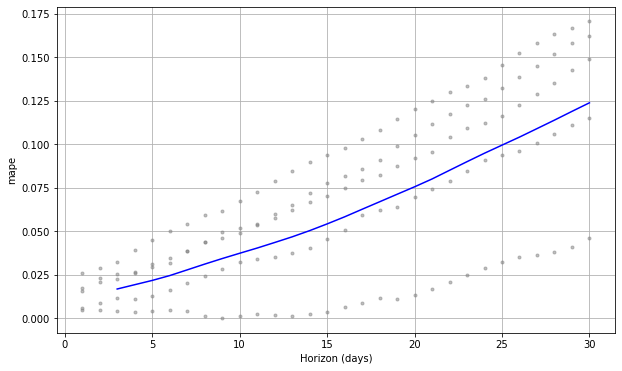

In [29]:
df_performance=plot_cross_validation_metric(df_cv,metric='mape')